In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

import numpy as np
import numpy.ma as ma
import os
import xarray as xr
import glob
# import loadobservations as lo
from esio import import_data
from esio import metrics
from esio import EsioData as ed

# Dirs
E = ed.EsioData.load()
data_dir = E.obs_dir

# Flags
UpdateAll = False

# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

# Products to import
product_list = ['NSIDC_0081', 'NSIDC_0051', 'NSIDC_0079']

# Version numbers (if any)
# If multiple version number files exist, it only imports the one specified below
ver_nums = {'NSIDC_0079':'v3.1','NSIDC_0081':'nrt','NSIDC_0051':'v1.1'}

ds_lat_lon = import_data.get_stero_N_grid(grid_dir=E.grid_dir)

In [2]:
#print(ds_lat_lon)
#print(ds_region)

<xarray.Dataset>
Dimensions:  (x: 304, y: 448)
Dimensions without coordinates: x, y
Data variables:
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
<xarray.Dataset>
Dimensions:        (nregions: 21, ocean_regions: 14, x: 304, y: 448)
Coordinates:
    lat            (x, y) float64 ...
    lon            (x, y) float64 ...
    region_names   (nregions) object ...
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 296 297 298 299 300 301 302 303
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 440 441 442 443 444 445 446 447
    hole_mask      (y, x) int8 ...
    xm             (x) int64 ...
    ym             (y) int64 ...
  * nregions       (nregions) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20 21
  * ocean_regions  (ocean_regions) int64 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    mask           (x, y) int32 ...
    area           (x, y) float32 ...


<xarray.DataArray 'region_names' (nregions: 21)>
array(['Ice-free Oceans', 'Sea of Okhotsk', 'Bering', 'Hudson Bay', 'St John',
       'Baffin Bay', 'East Greenland Sea', 'Barents Sea', 'Kara Sea',
       'Laptev Sea', 'East Siberian Sea', 'Chukchi Sea', 'Beaufort Sea',
       'Canadian Islands', 'Central Arctic', 'null', 'null', 'null', 'null',
       'land', 'land outline'], dtype=object)
Coordinates:
    region_names  (nregions) object 'Ice-free Oceans' ... 'land outline'
  * nregions      (nregions) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21


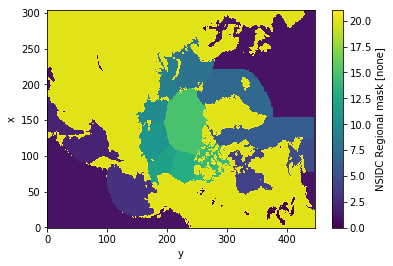

In [3]:
#import matplotlib

#ds_region.mask.plot()
#print(ds_region.region_names)


In [ ]:
# Loop through each product
for c_product in product_list:
    print('Importing ', c_product, '...')

    # Find new files that haven't been imported yet
    native_dir = os.path.join(data_dir, c_product, 'native')
    os.chdir(native_dir)
    native_files = sorted(glob.glob('*'+ver_nums[c_product]+'*.bin'))
    nc_dir = os.path.join(data_dir, c_product, 'sipn_nc')
    os.chdir(nc_dir)
    nc_files = sorted(glob.glob('*.nc'))
    if UpdateAll:
        new_files = [x.split('.b')[0] for x in native_files]
        print('Updating all ', len(native_files), ' files...')
    else:
        new_files = np.setdiff1d([x.split('.b')[0] for x in native_files], 
                                 [x.split('.n')[0] for x in nc_files]) # just get file name and compare
        print('Found ', len(new_files), ' new files to import...')

    # Loop through each file
    for nf in new_files:
        
        # Load in 
        ds_sic = import_data.load_1_NSIDC(filein=os.path.join(native_dir, nf+'.bin'), product=c_product)

        # Add lat and lon dimensions
        ds_sic.coords['lat'] = ds_lat_lon.lat
        ds_sic.coords['lon'] = ds_lat_lon.lon

        # Stereo projected units (m)
        dx = dy = 25000 
        xm = np.arange(-3850000, +3750000, +dx)
        ym = np.arange(+5850000, -5350000, -dy)
        ds_sic.coords['xm'] = xr.DataArray(xm, dims=('x'))
        ds_sic.coords['ym'] = xr.DataArray(ym, dims=('y'))    

        # get lats around the pole hole
        hole_mask = ds_sic.hole_mask  
        lats = ds_sic.lat.where(hole_mask==1)
        LMAX=lats.min().values
        
        land_mask = ds_sic.sic.notnull() # use latest
        land_mask = land_mask.where(hole_mask==0, other=1)

        # avg concentration in annular ring around pole hole
        sic_polehole=ds_sic.where(land_mask & (ds_sic.lat<LMAX) & (ds_sic.lat>LMAX-1)).sic.mean().values
#        print('stuff ',sic_polehole, LMAX)

        # Old way of computing extent and area
        # ds_sic['extent'] = metrics.calc_extent(ds_sic.sic, ds_region, fill_pole_hole=True)
        # print('extent force fill it', ds_sic['extent'])
        # ds_sic['area'] = (ds_sic.sic * ds_region.area).sum(dim='x').sum(dim='y')/(10**6) # No pole hole
        # print('no fill areas ',ds_sic.area)
        
        # fill pole hole with neighbor values
        ds_sic = ds_sic.where(hole_mask==0, other=sic_polehole)
        
        # New results of extent and area after pole hole fill
        # must not have TRUE or double counts the pole hole
        # ds_sic['extent'] = metrics.calc_extent(ds_sic.sic, ds_region, fill_pole_hole=True)
        # print('double counts it', ds_sic['extent'])

        ds_sic['extent'] = metrics.calc_extent(ds_sic.sic, ds_region, fill_pole_hole=False)
#        ds_sic.sic.plot()

#         ds_sic['extent'] = ds_sic['extent'] + (ds_sic.hole_mask.astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6) # Add hole
        ds_sic['area'] = (ds_sic.sic * ds_region.area).sum(dim='x').sum(dim='y')/(10**6) # No pole hole

#        print('extent and areas ',ds_sic.extent.values, ds_sic.area.values, sic_polehole, LMAX)
        # Save to netcdf file
        ds_sic.to_netcdf(os.path.join(nc_dir, nf.split('.b')[0]+'.nc'))
        ds_sic = None

#     # Calculate extent and area (saved to separte file)
#     if len(new_files) > 0 : # There were some new files
#         print('Calculating extent and area...')
#         ds_all = xr.open_mfdataset(os.path.join(nc_dir,'*.nc'), concat_dim='time', 
#                                    autoclose=True, compat='no_conflicts',
#                                    data_vars=['sic'])    
#         print('Loaded in all files...')
#         ds_all['extent'] = ((ds_all.sic>=0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
#         ds_all['extent'] = ds_all['extent'] + (ds_all.hole_mask.astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6) # Add hole
#         ds_all['area'] = (ds_all.sic * ds_region.area).sum(dim='x').sum(dim='y')/(10**6) # No pole hole
#         ds_all = ds_all[['extent','area']]
#         # Create new dir to store agg file
#         if not os.path.exists(os.path.join(data_dir, c_product, 'agg_nc')):
#             os.makedirs(os.path.join(data_dir, c_product, 'agg_nc'))
#         ds_all.to_netcdf(os.path.join(data_dir, c_product, 'agg_nc', 'panArctic.nc'))
        
    # For each Product
    print("Finished ", c_product)
    print("")

Importing  NSIDC_0081 ...
Found  1556  new files to import...
extent and areas  12.913136970245361 11.69848046745982 0.9961891891891892 89.18409000000001
extent and areas  12.93334278994751 11.715527275697694 0.9965675675675677 89.18409000000001
extent and areas  12.955405529571534 11.80235542921951 0.9980810810810812 89.18409000000001
extent and areas  12.957251155059815 11.78179720556305 0.9995675675675676 89.18409000000001
extent and areas  13.052415026733398 11.842044119684076 0.9997297297297297 89.18409000000001
extent and areas  13.03245528479004 11.867724467960597 0.9910810810810812 89.18409000000001
extent and areas  13.013703225128173 11.826948116410612 0.9876486486486487 89.18409000000001
extent and areas  13.055300068603515 11.865230771455664 0.988054054054054 89.18409000000001
extent and areas  13.12473381994629 11.844108422141618 0.9896756756756757 89.18409000000001
extent and areas  13.098754386688233 11.868803704718752 0.9901351351351351 89.18409000000001
extent and area

extent and areas  14.131578035095215 12.884438231550826 0.9818918918918919 89.18409000000001
extent and areas  14.063763198760986 12.844498257563956 0.9905945945945946 89.18409000000001
extent and areas  14.06479475088501 12.856923610617445 0.9985405405405405 89.18409000000001
extent and areas  13.988988829864502 12.815879271830417 0.9999189189189189 89.18409000000001
extent and areas  13.893173172271728 12.723774382251348 0.9972702702702703 89.18409000000001
extent and areas  13.918008713378907 12.67323988965039 1.0 89.18409000000001
extent and areas  13.944652115600586 12.703451414690804 0.9952702702702704 89.18409000000001
extent and areas  13.999220558807373 12.74223629928501 0.998054054054054 89.18409000000001
extent and areas  14.07518070135498 12.801739095482557 0.9975405405405408 89.18409000000001
extent and areas  13.952839337066651 12.692104905748394 0.9981891891891894 89.18409000000001
extent and areas  13.961416363159179 12.681318357859556 0.9974324324324325 89.184090000000

extent and areas  9.641246380493165 6.832595628568947 0.982054054054054 89.18409000000001
extent and areas  9.439044078460693 6.638811553982504 0.9533783783783784 89.18409000000001
extent and areas  9.382616734863282 6.5484596674132804 0.8879729729729731 89.18409000000001
extent and areas  9.256356673797608 6.436147317288466 0.8705405405405405 89.18409000000001
extent and areas  9.051098247711181 6.338848026027726 0.8726756756756757 89.18409000000001
extent and areas  9.010645308715821 6.2207116690732 0.8572432432432432 89.18409000000001
extent and areas  8.86658643710327 6.117460821473295 0.8482162162162163 89.18409000000001
extent and areas  8.71184717098999 6.020451682954542 0.852030303030303 89.18409000000001
extent and areas  8.74341466796875 5.908476027659522 0.8460540540540541 89.18409000000001
extent and areas  8.612848660430908 5.784858520081511 0.8716486486486485 89.18409000000001
extent and areas  8.400662420013427 5.667427220762998 0.8794324324324325 89.18409000000001
exten

extent and areas  5.48483793737793 4.216744215097412 0.918 89.18409000000001
extent and areas  5.6365634742431645 4.369219764004038 0.9124054054054054 89.18409000000001
extent and areas  5.7719509872436525 4.540510667173399 0.8614324324324325 89.18409000000001
extent and areas  5.958388058410645 4.636905019962025 0.8745945945945945 89.18409000000001
extent and areas  6.095601491821289 4.7612648627414185 0.8485135135135136 89.18409000000001
extent and areas  6.2032749523925785 4.85048450584349 0.8683243243243244 89.18409000000001
extent and areas  6.2514460851440425 4.949838675070801 0.91 89.18409000000001
extent and areas  6.293617727233887 5.044482322162832 0.9515945945945947 89.18409000000001
extent and areas  6.354450854980469 5.169137064183881 0.9567567567567568 89.18409000000001
extent and areas  6.51569231048584 5.343998567648126 0.9503561643835617 89.18409000000001
extent and areas  6.678876030822754 5.517240379729295 0.9228918918918918 89.18409000000001
extent and areas  6.9027

extent and areas  13.026308010162353 11.810424890711428 1.0 89.18409000000001
extent and areas  13.183827442382812 11.93875166119348 1.0 89.18409000000001
extent and areas  13.351025336364746 11.96760146666516 1.0 89.18409000000001
extent and areas  13.28441019833374 11.89687413075354 1.0 89.18409000000001
extent and areas  13.39672164163208 11.91828959129065 1.0 89.18409000000001
extent and areas  13.357273690582275 11.963480853473632 1.0 89.18409000000001
extent and areas  13.332346071472168 11.998388911139038 1.0 89.18409000000001
extent and areas  13.355237821197509 12.063007687277832 1.0 89.18409000000001
extent and areas  13.402432496520996 12.129255590306885 1.0 89.18409000000001
extent and areas  13.44436718685913 12.171941806268595 0.999700680272109 89.18409000000001
extent and areas  13.442080198425293 12.159173650982146 0.9996486486486487 89.18409000000001
extent and areas  13.4506396506958 12.14977676638713 0.9980136054421769 89.18409000000001
extent and areas  13.529127997

extent and areas  13.695687863739014 12.328801414658814 1.0 89.18409000000001
extent and areas  13.752057163574218 12.315433034807617 1.0 89.18409000000001
extent and areas  13.714218895874023 12.287878309054687 1.0 89.18409000000001
extent and areas  13.658509548675537 12.283252656756348 1.0 89.18409000000001
extent and areas  13.670536059783936 12.288823973199095 1.0 89.18409000000001
extent and areas  13.505286017913818 12.230072549671267 1.0 89.18409000000001
extent and areas  13.425993920715332 12.091692465346192 1.0 89.18409000000001
extent and areas  13.508941091552735 12.086692315320802 1.0 89.18409000000001
extent and areas  13.439403088684083 12.033129128070314 1.0 89.18409000000001
extent and areas  13.444626608917236 11.980962513635742 1.0 89.18409000000001
extent and areas  13.3953572678833 11.933301216125853 1.0 89.18409000000001
extent and areas  13.306917265655517 11.852537993875488 1.0 89.18409000000001
extent and areas  13.217847387145996 11.747761835987793 1.0 89.184

extent and areas  7.844056364654541 5.282020903210636 0.8037027027027027 89.18409000000001
extent and areas  7.74388908468628 5.198574103226401 0.8203783783783783 89.18409000000001
extent and areas  7.666819635223389 5.191884621312095 0.8333783783783784 89.18409000000001
extent and areas  7.52531218258667 5.113003654205411 0.8146486486486486 89.18409000000001
extent and areas  7.462521653533935 4.978453366093131 0.8425945945945945 89.18409000000001
extent and areas  7.383562362121582 4.932097107242616 0.7995675675675675 89.18409000000001
extent and areas  7.29025723513794 4.923647292206144 0.8576486486486485 89.18409000000001
extent and areas  7.2531591199035645 4.83985611950559 0.818918918918919 89.18409000000001
extent and areas  7.201000547943115 4.791926969278178 0.8731891891891892 89.18409000000001
extent and areas  7.16909401248169 4.735608476457426 0.9102162162162162 89.18409000000001
extent and areas  7.135780783935547 4.6699047418049116 0.8751891891891891 89.18409000000001
ext

extent and areas  5.79931860168457 4.30878496201641 0.6953093525179855 89.18409000000001
extent and areas  5.873286342102051 4.378291237734629 0.7144054054054054 89.18409000000001
extent and areas  5.922630704284668 4.426566687921889 0.7115405405405406 89.18409000000001
extent and areas  6.0950058025512694 4.575987557318168 0.6961621621621621 89.18409000000001
extent and areas  6.305807817871094 4.763032656765922 0.6891621621621621 89.18409000000001
extent and areas  6.460043114990234 4.881009365072879 0.6881351351351351 89.18409000000001
extent and areas  6.577453776672363 4.943592169825305 0.6964594594594594 89.18409000000001
extent and areas  6.698207469848633 5.084799894287548 0.703972972972973 89.18409000000001
extent and areas  6.788167241455078 5.23913149310674 0.714027027027027 89.18409000000001
extent and areas  6.949435284362793 5.37786851162951 0.7357297297297297 89.18409000000001
extent and areas  6.959318706298828 5.364808738253187 0.7445405405405405 89.18409000000001
exte

extent and areas  12.778414463897706 11.363597533040425 0.8958108108108107 89.18409000000001
extent and areas  12.874864066680908 11.434535086493591 0.8954324324324324 89.18409000000001
extent and areas  12.862215419219972 11.425399777679528 0.8815135135135135 89.18409000000001
extent and areas  12.936785161956788 11.412798627325433 0.8797297297297296 89.18409000000001
extent and areas  13.071159646911621 11.494171233010869 0.8802702702702703 89.18409000000001
extent and areas  13.215775121124267 11.581453587136936 0.8759189189189189 89.18409000000001
extent and areas  13.277573786499023 11.721147227700502 0.8855675675675675 89.18409000000001
extent and areas  13.373039170715332 11.871745463000495 0.8832702702702702 89.18409000000001
extent and areas  13.52045301321411 11.995314941620062 0.8928378378378378 89.18409000000001
extent and areas  13.609193814697266 12.022930818521917 0.9027027027027028 89.18409000000001
extent and areas  13.613651562530517 12.05855895857577 0.90451351351351

extent and areas  13.611453563903808 12.438996702057674 0.9982972972972972 89.18409000000001
extent and areas  13.609319535491943 12.446610526844482 0.999 89.18409000000001
extent and areas  13.627367289703368 12.425176199615137 0.9960810810810812 89.18409000000001
extent and areas  13.570251344573975 12.324645948369664 0.9984864864864865 89.18409000000001
extent and areas  13.500588216796874 12.307833166400025 1.0 89.18409000000001
extent and areas  13.466184596038818 12.367830851198118 1.0 89.18409000000001
extent and areas  13.40258292730713 12.33617985018384 1.0 89.18409000000001
extent and areas  13.384154568206787 12.312052308854565 0.999972972972973 89.18409000000001
extent and areas  13.391301870544433 12.300602582614392 0.9965405405405405 89.18409000000001
extent and areas  13.386832471862792 12.27714816261588 0.9974864864864866 89.18409000000001
extent and areas  13.36753866659546 12.220262897425759 0.9930540540540541 89.18409000000001
extent and areas  13.378294046813965 12.

extent and areas  7.763010750396728 5.773195993148834 0.9442162162162162 89.18409000000001
extent and areas  7.637752980926514 5.592487376376366 0.9739459459459457 89.18409000000001
extent and areas  7.515044261260987 5.412063466220389 0.8831621621621624 89.18409000000001
extent and areas  7.3924983565979 5.264394264603958 0.883108108108108 89.18409000000001
extent and areas  7.240359030426025 5.091297365051659 0.8519459459459459 89.18409000000001
extent and areas  7.287201290863037 5.112581074722257 0.9046486486486485 89.18409000000001
extent and areas  7.324921929016114 5.0913227590781585 0.9213513513513513 89.18409000000001
extent and areas  7.239928613433838 5.037516464289954 0.8934864864864864 89.18409000000001
extent and areas  7.147361014312744 4.982746376398831 0.878081081081081 89.18409000000001
extent and areas  7.121439340545654 4.9538870790768055 0.9459459459459459 89.18409000000001
extent and areas  7.000743804016113 4.942899988948694 0.9815135135135136 89.18409000000001
e

extent and areas  6.5950782050170895 5.246580260557604 0.7214594594594593 89.18409000000001
extent and areas  6.766757004211426 5.386456315862602 0.708162162162162 89.18409000000001
extent and areas  6.969896297973633 5.582254481124842 0.7345135135135135 89.18409000000001
extent and areas  7.124948844665528 5.768054069258987 0.7201081081081082 89.18409000000001
extent and areas  7.231327050109863 5.894371572841823 0.739081081081081 89.18409000000001
extent and areas  7.3987138850708005 5.989424615468579 0.760972972972973 89.18409000000001
extent and areas  7.5072618368530275 6.127305307959773 0.7872972972972971 89.18409000000001
extent and areas  7.598366965820312 6.269436307503227 0.7931621621621622 89.18409000000001
extent and areas  7.559786096862793 6.282492237648115 0.7867567567567567 89.18409000000001
extent and areas  7.599224894958496 6.339627084864106 0.8007837837837838 89.18409000000001
extent and areas  7.721932631652832 6.49153762628776 0.8066216216216215 89.18409000000001


extent and areas  12.944556606842042 11.75459230594578 0.9931891891891891 89.18409000000001
extent and areas  12.999105094848632 11.758041715674024 0.993972972972973 89.18409000000001
extent and areas  12.991088263061524 11.780786650937358 0.9951891891891893 89.18409000000001
extent and areas  13.005300967651367 11.862206930248652 0.9957297297297297 89.18409000000001
extent and areas  13.051826679229736 11.893344066435947 0.9954864864864864 89.18409000000001
extent and areas  13.039320345733643 11.968907244964894 0.9940270270270269 89.18409000000001
extent and areas  13.054684229980468 11.98848558794307 0.9991081081081081 89.18409000000001
extent and areas  13.02407298550415 11.960257698290892 1.0 89.18409000000001
extent and areas  13.07478490057373 12.037786422087349 0.9998378378378379 89.18409000000001
extent and areas  13.173332838897705 12.13797921702063 1.0 89.18409000000001
extent and areas  13.231223482513428 12.188405425742527 0.9999189189189189 89.18409000000001
extent and ar

extent and areas  13.560703668426514 12.405239925701782 1.0 89.18409000000001
extent and areas  13.469705254730224 12.342287860797365 1.0 89.18409000000001
extent and areas  13.424335019104005 12.317752184657104 1.0 89.18409000000001
extent and areas  13.37315882800293 12.347212612118529 1.0 89.18409000000001
extent and areas  13.280001918945313 12.31348656011206 1.0 89.18409000000001
extent and areas  13.240535263702393 12.212906770215332 1.0 89.18409000000001
extent and areas  13.301693368927001 12.273795451264403 1.0 89.18409000000001
extent and areas  13.281696969177245 12.27141786370398 1.0 89.18409000000001
extent and areas  13.308997325012207 12.25698543828369 1.0 89.18409000000001
extent and areas  13.262048285369874 12.232567324091066 1.0 89.18409000000001
extent and areas  13.182489111907959 12.148100768615965 1.0 89.18409000000001
extent and areas  13.188508817138672 12.111966834909182 1.0 89.18409000000001
extent and areas  13.080811018280029 12.057434088254395 1.0 89.18409

extent and areas  7.7273124536437985 5.395539134975629 0.8757567567567569 89.18409000000001
extent and areas  7.525276242340088 5.3074283716006 0.9705405405405404 89.18409000000001
extent and areas  7.383637312774658 5.136482061004784 0.9929459459459459 89.18409000000001
extent and areas  7.263923708648681 5.152066597874511 1.0 89.18409000000001
extent and areas  7.174785373901368 5.097558085173217 1.0 89.18409000000001
extent and areas  7.128930678649902 5.000224554274652 0.9977297297297296 89.18409000000001
extent and areas  7.051337901367187 4.900880760256863 0.8800810810810812 89.18409000000001
extent and areas  7.023421781188965 4.904734963779254 0.9352432432432433 89.18409000000001
extent and areas  6.811810017730713 4.885056563003972 0.9547027027027026 89.18409000000001
extent and areas  6.558808121063232 4.781928391478668 0.9282162162162162 89.18409000000001
extent and areas  6.573522165863037 4.815909804384106 0.983972972972973 89.18409000000001
extent and areas  6.45719260089

extent and areas  6.365865434448242 4.975417593056568 0.810027027027027 89.18409000000001
extent and areas  6.557744477722168 5.15525166406856 0.8152432432432433 89.18409000000001
extent and areas  6.68765384173584 5.325295260016074 0.8133783783783783 89.18409000000001
extent and areas  6.879293763671875 5.490820719618239 0.8191081081081082 89.18409000000001
extent and areas  7.0752867282104495 5.6564486565981715 0.8100810810810811 89.18409000000001
extent and areas  7.398811351501465 5.835535108404584 0.7817567567567567 89.18409000000001
extent and areas  7.647764680175781 5.995207776304662 0.7819189189189188 89.18409000000001
extent and areas  7.580559437194824 6.096954389946254 0.8025135135135134 89.18409000000001
extent and areas  7.617905004760742 6.187024191776472 0.8263243243243243 89.18409000000001
extent and areas  7.8175581640625 6.33775444441204 0.8491621621621622 89.18409000000001
extent and areas  8.053153813415527 6.49899787454889 0.8395675675675676 89.18409000000001
exte

extent and areas  13.676044303771972 12.531224603838679 0.9802972972972973 89.18409000000001
extent and areas  13.703405123046876 12.621440626867692 0.9806756756756756 89.18409000000001
extent and areas  13.63442477557373 12.638521009956797 0.9754054054054053 89.18409000000001
extent and areas  13.710310553955079 12.674520413544096 0.9692162162162161 89.18409000000001
extent and areas  13.743408261932373 12.72200768075112 0.9769459459459459 89.18409000000001
extent and areas  13.768238089874268 12.754680661680444 0.980081081081081 89.18409000000001
extent and areas  13.800277447662353 12.750955894401617 0.9852702702702704 89.18409000000001
extent and areas  13.855819584930419 12.762713058136953 0.9835945945945946 89.18409000000001
extent and areas  13.886445405700684 12.794295132725452 0.9654594594594593 89.18409000000001
extent and areas  13.83647360333252 12.788943337306053 0.9719459459459459 89.18409000000001
extent and areas  13.907042154937745 12.82931399732143 0.9848108108108109 

extent and areas  12.961254174316407 12.148958853301473 0.9858798283261803 84.53063
extent and areas  13.10848805847168 12.254902542006336 0.988860248447205 84.88178
extent and areas  13.178634607666016 12.322685819397996 0.9852875536480686 84.53063
extent and areas  13.313179198059082 12.44223486005601 0.9812810559006212 84.88178
extent and areas  13.445649677398682 12.56350415594117 0.9836685962373373 84.52093
extent and areas  13.749048235168457 12.835515781233818 0.9847724550898204 84.65835000000001
extent and areas  13.971303396270752 13.061034436252925 0.9820046583850931 84.88178
extent and areas  13.96822595578003 13.124984615772663 0.987688596491228 84.81988000000001
extent and areas  14.230637170196534 13.228395804692495 0.9897949101796407 84.6683
extent and areas  14.228298164459229 13.34086341083095 0.984743553008596 84.48230000000001
extent and areas  14.313323317199707 13.405798495979269 0.9800745614035088 84.81988000000001
extent and areas  14.523974163482666 13.617492502

extent and areas  13.147429291931152 11.876480538156851 0.9939713876967097 84.53063
extent and areas  12.99158836883545 11.724463378463316 0.9928624641833811 84.48230000000001
extent and areas  12.99726397442627 11.655710578435293 0.9921630901287553 84.53063
extent and areas  12.721055809448242 11.50435319212101 0.9869785407725322 84.53063
extent and areas  12.581645213684082 11.28892186655912 0.9889684813753581 84.48230000000001
extent and areas  12.545136388916015 11.087606308463156 0.9872460658082974 84.53063
extent and areas  12.511167378845215 10.829667467804239 0.987274678111588 84.53063
extent and areas  12.373007450805664 10.585349991558004 0.9861156069364163 84.57939
extent and areas  12.289230173583984 10.440483534470566 0.9784580745341614 84.88178
extent and areas  12.095199964172362 10.076760766133868 0.9609356223175965 84.53063
extent and areas  12.1775228359375 10.385391943113445 0.9831704871060173 84.48230000000001
extent and areas  12.055971579406739 10.36125551847096 0

extent and areas  13.577045154449463 12.821941221471398 0.9847806748466258 84.90258
extent and areas  13.815883236083984 12.926077852573663 0.9803194444444443 84.36800000000001
extent and areas  13.983462078125 12.964889155698538 0.9801373390557939 84.53063
extent and areas  14.084534382354736 13.052647940562375 0.9772627118644067 84.60886
extent and areas  14.20312175643921 13.25101672271976 0.979940828402367 84.68826000000001
extent and areas  14.338318995391846 13.417162992421057 0.9745263975155279 84.88178
extent and areas  14.425246771362305 13.481048036878548 0.9785450310559007 84.88178
extent and areas  14.451667515411376 13.522042596097004 0.9815014970059881 84.65835000000001
extent and areas  14.530677797271728 13.60610552676307 0.9808944099378882 84.88178
extent and areas  14.610746104400635 13.613090344362266 0.9779221556886227 84.65835000000001
extent and areas  14.623568544403076 13.716905697419767 0.9811530758226038 84.53063
extent and areas  14.777427585784912 13.8394922

extent and areas  12.12667021722412 10.549184101708835 0.9954655688622754 84.6683
extent and areas  12.048611467346191 10.489394341402743 0.9946944444444445 84.81988000000001
extent and areas  11.977795432495117 10.41441038817952 0.9806343930635837 84.79942000000001
extent and areas  11.725704634765625 10.322476799141429 0.9755295031055901 84.88178
extent and areas  11.60099476940918 10.171274895574044 0.9827335329341318 84.77903
extent and areas  11.481423468261719 10.041696341557495 0.9816601796407186 84.65835000000001
extent and areas  11.400578345458984 9.91337237117643 0.9768078034682082 84.57939
extent and areas  11.358161621765136 9.75207717594252 0.9774565868263474 84.77903
extent and areas  11.218652026428222 9.625769547029615 0.9844349112426036 84.68826000000001
extent and areas  11.031087223144532 9.411340702787912 0.9833453757225432 84.79942000000001
extent and areas  10.899819030395507 9.223277825481336 0.9842298136645964 84.88178
extent and areas  10.664171534423827 8.958

extent and areas  14.662685826660157 13.737926146890622 0.987032608695652 84.88178
extent and areas  14.866543260192872 13.973482300272632 0.994447782546495 84.53063
extent and areas  14.83082164642334 13.721166175781272 0.9927018633540372 84.93395000000001
extent and areas  14.897227921722411 13.867557901704409 0.9932455089820359 84.65835000000001
extent and areas  14.821897341461181 13.894766627058614 0.9896614906832298 84.93395000000001
extent and areas  14.876559970672607 13.93907316639785 0.9857484472049689 84.88178
extent and areas  15.164942002044677 14.216937794564222 0.9880419075144508 84.57939
extent and areas  15.220257369628905 14.265172281098367 0.9829782608695652 84.93395000000001
extent and areas  15.19867304916382 14.262771887978031 0.9835688622754492 84.77903
extent and areas  15.273774425811768 14.340106530643853 0.9914503105590061 84.88178
extent and areas  15.395800953125 14.417265939521076 0.9860745341614907 84.93395000000001
extent and areas  15.5295786534729 14.5

extent and areas  11.102256496459962 9.225364321649229 0.9846497005988024 84.77903
extent and areas  10.874189983764648 8.986292738929357 0.9860260115606937 84.57939
extent and areas  10.666658506347657 8.653753742376919 0.9760336257309941 84.81988000000001
extent and areas  10.605413834838867 8.634633241440813 0.9822875722543354 84.79942000000001
extent and areas  10.410651138305663 8.423136180418183 0.9861842105263158 84.81988000000001
extent and areas  10.173142645874023 8.286445358112418 0.9862290419161676 84.77903
extent and areas  10.070242697570801 7.994027400330959 0.9860014792899409 84.80964
extent and areas  9.95586437701416 7.870628631521231 0.9853728323699422 84.79942000000001
extent and areas  9.59818620111084 7.563321525251549 0.9680791925465838 84.88178
extent and areas  9.425567216369629 7.60295547367339 0.988065808297568 84.53063
extent and areas  9.267222220581054 7.332056685503541 0.9760266272189349 84.74860000000001
extent and areas  9.011124963562011 7.273364676181

extent and areas  15.433048832824706 14.58419596360031 0.9824844720496895 84.88178
extent and areas  15.62467423248291 14.72058913501524 0.9820494011976049 84.6683
extent and areas  15.713166432556152 14.823989297999256 0.9776552217453506 84.53063
extent and areas  15.750054716796875 14.89294066480317 0.9786569444444445 84.36800000000001
extent and areas  15.822760022979736 15.010237926823404 0.9804751552795031 84.88178
extent and areas  15.821438015289306 14.976921434476605 0.9848727810650888 84.71834000000001
extent and areas  15.870258114929198 15.009180448507465 0.9850232919254659 84.89217000000001
extent and areas  15.843924018951416 15.004949272203644 0.9861599378881988 84.88178
extent and areas  15.83048291796875 14.931235842669507 0.9895341614906832 84.88178
extent and areas  15.803565201965332 14.97990596919078 0.9912997076023391 84.78921000000001
extent and areas  15.92321566104126 15.04275820907358 0.9903937125748502 84.77903
extent and areas  15.954657559509277 14.992215298

extent and areas  9.668401014404298 7.966933494833946 0.9913131034482758 84.27451
extent and areas  9.424769422058105 7.831888305932115 0.9919895209580837 84.77903
extent and areas  9.294591295898437 7.797097656047814 0.9877572413793104 84.27451
extent and areas  9.22421043725586 7.750180680339016 0.9855372670807454 84.88178
extent and areas  9.027965283935547 7.566191907999892 0.9787067238912732 84.53063
extent and areas  8.992181226379394 7.446753087900266 0.9759356725146199 84.81988000000001
extent and areas  8.864328577087402 7.404007768446319 0.9726965517241379 84.27451
extent and areas  8.61744597265625 7.317519928239944 0.9654260355029585 84.85074
extent and areas  8.531787961791991 7.1770548421955285 0.9736208333333334 84.36800000000001
extent and areas  8.36335056427002 7.058524133050127 0.9591909937888198 84.88178
extent and areas  8.38025391027832 7.080018001241276 0.9753213793103448 84.27451
extent and areas  8.179004804992676 6.905195202629468 0.9732233727810651 84.6882600

extent and areas  15.920171700378418 14.954403192270123 0.9745103550295858 84.74860000000001
extent and areas  16.107137447631835 15.096264756164212 0.9695458579881657 84.74860000000001
extent and areas  16.16019822442627 15.187423581626614 0.9722958579881655 84.74860000000001
extent and areas  16.05976880264282 15.098006344565231 0.9727170658682635 84.77903
extent and areas  16.180203280548096 15.216551552282464 0.9839615384615384 84.74860000000001
extent and areas  16.22398784625244 15.329860920381591 0.9912020958083833 84.77903
extent and areas  16.410961657684325 15.426252912560415 0.9894910179640719 84.77903
extent and areas  16.506031603118895 15.521336528221827 0.9886781437125749 84.77903
extent and areas  16.39951908380127 15.486886437928085 0.9833696275071633 84.48230000000001
extent and areas  16.24723352536011 15.39283692802732 0.9893872832369941 84.57939
extent and areas  16.123402458831787 15.322889333259166 0.9850194610778444 84.77903
extent and areas  16.049001079803467 

extent and areas  8.450156831176757 6.997179082945235 0.9839347826086956 84.88178
extent and areas  8.477542030090332 7.001845157145916 0.984329479768786 84.79942000000001
extent and areas  8.373823083984375 6.923516079045197 0.9825636094674556 84.68826000000001
extent and areas  8.23641940222168 6.866177850594251 0.9751796407185628 84.77903
extent and areas  8.096765440185546 6.812667111351682 0.9786257225433526 84.79942000000001
extent and areas  8.159477729248048 6.8327239721047 0.9780384615384615 84.74860000000001
extent and areas  8.054235435302735 6.80079731911209 0.9791358381502888 84.79942000000001
extent and areas  8.017086397216797 6.763314078127205 0.9751094674556212 84.74860000000001
extent and areas  7.989808054443359 6.779263817162058 0.9803550295857989 84.74860000000001
extent and areas  7.961750877197265 6.758363082529284 0.9807455621301774 84.74860000000001
extent and areas  7.946405122375488 6.805113853831736 0.9856849710982659 84.57939
extent and areas  7.98108350006

extent and areas  15.629960178466797 14.729166932250187 0.9842140718562875 84.77903
extent and areas  15.654736915588378 14.612542753764659 0.9840710059171597 84.74860000000001
extent and areas  15.678427505706788 14.65600235251956 0.984548245614035 84.81988000000001
extent and areas  15.525624625061035 14.579380514166191 0.9866497005988024 84.77903
extent and areas  15.590722419342042 14.693105089419854 0.9804041916167664 84.77903
extent and areas  15.602580149353027 14.694833807969246 0.9809812138728323 84.57939
extent and areas  15.593551638824463 14.69432165560456 0.9838453757225433 84.79942000000001
extent and areas  15.62670185647583 14.759129866124729 0.9829548022598871 84.60886
extent and areas  15.681995096496582 14.775355834509007 0.9883439306358381 84.79942000000001
extent and areas  15.782640396484375 14.843938874178457 0.9903846153846154 84.74860000000001
extent and areas  15.872876705200195 14.95306987760484 0.9932380239520957 84.77903
extent and areas  15.867816905700684

extent and areas  7.534345354553222 6.446542427316457 0.9637363896848138 84.48230000000001
extent and areas  7.354507329711914 6.249846989653092 0.9576848137535817 84.48230000000001
extent and areas  7.333858766784668 6.202832210049398 0.9585069832402234 84.59902000000001
extent and areas  7.246311133972168 6.187115855320534 0.9652627118644067 84.55008000000001
extent and areas  7.2925348157348635 6.242216883097399 0.9724176300578035 84.57939
extent and areas  7.387511928100586 6.401567543918684 0.9645108538350217 84.52093
extent and areas  7.289756074584961 6.286212999114175 0.9734427586206897 84.27451
extent and areas  7.308218954956055 6.281903405761862 0.9794407514450869 84.57939
extent and areas  7.415713280090332 6.431604833565138 0.9841678726483357 84.52093
extent and areas  7.605498439025879 6.659042479712767 0.9803468208092485 84.57939
extent and areas  7.7896124192504885 6.864291005314809 0.9796632947976878 84.57939
extent and areas  7.889664032897949 7.01679058705005 0.97609

extent and areas  16.043365042541502 15.167024088317497 0.9819782608695652 84.88178
extent and areas  16.122421817199708 15.22385178976038 0.9807109826589596 84.57939
extent and areas  16.063682553009034 15.199574478560258 0.9839394409937887 84.88178
extent and areas  16.003892554748536 15.251295911571425 0.988833850931677 84.88178
extent and areas  16.072183445800782 15.215285061430217 0.9863567251461987 84.81988000000001
extent and areas  16.13278874859619 15.204703166367791 0.9835962732919253 84.88178
extent and areas  16.094581931762697 15.115974270420857 0.9840077639751553 84.88178
extent and areas  15.943138579833985 14.957524501096588 0.9817384393063583 84.57939
extent and areas  15.88997868637085 14.83098171325785 0.980042899408284 84.74860000000001
extent and areas  15.562660169036866 14.688921670946181 0.9813084795321638 84.81988000000001
extent and areas  15.706778674865722 14.843485725944717 0.9820527950310559 84.88178
extent and areas  15.647136414886475 14.763679579764437

extent and areas  7.534304292541504 6.748475619789342 0.9866535087719299 84.81988000000001
extent and areas  7.557587961914063 6.752734257994181 0.9879248554913295 84.57939
extent and areas  7.618931319030762 6.883870494106787 0.9869736842105262 84.81988000000001
extent and areas  7.696528690734863 6.998755622852689 0.989266272189349 84.85074
extent and areas  7.816282260253907 7.124676093738163 0.9886199421965318 84.57939
extent and areas  7.964070917297363 7.273293742089175 0.9913354037267081 84.88178
extent and areas  8.181868192687988 7.504517374713603 0.9896925465838511 84.88178
extent and areas  8.27293665802002 7.569349650141591 0.9897267080745342 84.88178
extent and areas  8.394426851379395 7.752027456284694 0.9863788819875777 84.88178
extent and areas  8.527565900390625 7.956725331703335 0.9893973988439306 84.57939
extent and areas  8.611933090087891 8.083591413185758 0.9875494011976048 84.6683
extent and areas  8.731201174255371 8.16175959174482 0.9898990683229812 84.88178
ex

extent and areas  15.67475090246582 14.453978591050676 0.978887573964497 84.74860000000001
extent and areas  15.574442085784913 14.444722544250451 0.9782784431137724 84.65835000000001
extent and areas  15.523057969207764 14.393017139329002 0.989639751552795 84.93395000000001
extent and areas  15.451691493164063 14.351555748140845 0.9888649068322981 84.93395000000001
extent and areas  15.39890663812256 14.341182124641733 0.9929953416149069 84.89217000000001
extent and areas  15.326300816131592 14.260169110791058 0.9921319875776398 84.88178
extent and areas  15.134011247741698 14.147166754537981 0.9910739644970414 84.68826000000001
extent and areas  15.14044846234131 14.170609523235578 0.9905310559006212 84.88178
extent and areas  14.951919013824464 14.030108124379701 0.9925097765363129 84.59902000000001
extent and areas  14.896721708953857 13.893803704572637 0.9836174785100288 84.48230000000001
extent and areas  14.860362887207032 13.850306823355652 0.982945530726257 84.59902000000001
e

extent and areas  9.54987256842041 8.794682804381713 0.985559880239521 84.77903
extent and areas  9.676104471496583 8.952893886553408 0.9870409356725146 84.78921000000001
extent and areas  9.956495510986327 9.131987019494467 0.9889040114613179 84.48230000000001
extent and areas  10.089440799987793 9.31304419653821 0.9880695266272188 84.80964
extent and areas  10.084109872558594 9.426025006617266 0.9861459537572255 84.79942000000001
extent and areas  10.197589220581055 9.48422599302956 0.9852455089820359 84.77903
extent and areas  10.302764672180176 9.514570827574495 0.9895793413173652 84.77903
extent and areas  10.42571522607422 9.694620991458429 0.9876781437125749 84.65835000000001
extent and areas  10.486517561157227 9.782183438552439 0.9892701863354038 84.88178
extent and areas  10.571561892150878 9.883431690086804 0.985082298136646 84.88178
extent and areas  10.742107814025879 9.948785107538276 0.9895224550898203 84.65835000000001
extent and areas  10.814250190490723 10.05904377466

extent and areas  15.046663680847168 14.218654542100703 0.981812893081761 84.97607
extent and areas  15.004174530395508 14.13582350397126 0.9885321637426899 84.78921000000001
extent and areas  14.881774128875733 13.989602452761579 0.9846086956521739 84.93395000000001
extent and areas  14.793898439575194 13.833911229774827 0.9823957055214723 84.94444
extent and areas  14.699636767242431 13.745426458600436 0.9776511976047905 84.6683
extent and areas  14.587254407196045 13.526163598600329 0.978503105590062 84.93395000000001
extent and areas  14.5484668822937 13.50609925095685 0.9791180124223603 84.93395000000001
extent and areas  14.377788976104735 13.387849908968693 0.9822391304347826 84.88178
extent and areas  14.22989964086914 13.338274658384016 0.9846350931677019 84.88178
extent and areas  14.141274747802735 13.247690736227732 0.9884060693641616 84.57939
extent and areas  14.116239246490478 13.16158143179613 0.9925015527950312 84.88178
extent and areas  13.95739593081665 13.0672254491

extent and areas  7.909433303100586 6.974652006210757 0.9996915584415583 87.85389
extent and areas  8.057609713073731 7.112104900251039 1.0 87.87884000000001
extent and areas  8.081913430969239 7.196351692482649 0.9997564935064935 87.85389
extent and areas  8.102289096923828 7.23649182171778 0.9986038961038961 87.87884000000001
extent and areas  8.261522034790039 7.334609185996274 0.998922077922078 87.87884000000001
extent and areas  8.254364993896484 7.345478350226675 0.9996760563380283 87.95552
extent and areas  8.310730533874512 7.415271076859959 0.9994620253164558 87.78072
extent and areas  8.257969725646973 7.432895446139414 0.9996720779220779 87.87884000000001
extent and areas  8.432124280822753 7.550700606527539 0.9990227272727273 87.85389
extent and areas  8.429632168151855 7.575208148124839 0.9985949367088607 87.78072
extent and areas  8.49710342956543 7.672348360030321 0.9999014084507042 87.95552
extent and areas  8.564552523986816 7.703031966476055 0.9993333333333334 87.5526

extent and areas  15.724839585083007 14.738899426493104 0.9963028169014084 87.95552
extent and areas  15.758039303527832 14.69071538219272 0.9964999999999999 87.95552
extent and areas  15.677623720855713 14.638690142213811 0.9951654929577465 87.95552
extent and areas  15.577207303253173 14.58003207906697 0.9943390410958903 87.98172000000001
extent and areas  15.526673617218018 14.575264531371518 0.9917911392405062 87.66387
extent and areas  15.509193204589844 14.60563976114503 0.996708904109589 87.98172000000001
extent and areas  15.55100386920166 14.667010850802082 0.9956725352112676 87.95552
extent and areas  15.586919672729492 14.70737473926375 0.9972773972602741 87.98172000000001
extent and areas  15.663225925048827 14.769271688174218 0.9958169014084507 87.95552
extent and areas  15.685973128753663 14.755325354846413 0.9940246478873239 87.95552
extent and areas  15.696307650665283 14.795833822620896 0.9955950704225351 87.95552
extent and areas  15.67335925933838 14.826623335515457 

extent and areas  13.907380254211425 12.968391764143117 0.9877405063291138 87.78072
extent and areas  13.834218684051514 12.893811143826722 0.9904870129870131 87.85389
extent and areas  13.848742603118897 12.860682727077231 0.9897012987012986 87.85389
extent and areas  13.841083011291504 12.816065779845701 0.989525974025974 87.85389
extent and areas  13.782696823394776 12.754455605142553 0.9927113402061857 87.15068000000001
extent and areas  13.75257122277832 12.64881285126739 0.9970844155844155 87.85389
extent and areas  13.692816280334473 12.608022543139992 0.9963530927835051 87.05878000000001
extent and areas  13.646153748382568 12.531176385267056 0.998237012987013 87.85389
extent and areas  13.580016139160156 12.423512233828765 0.9983419540229885 87.50948000000001
extent and areas  13.46090306842041 12.353030340072424 0.9986525974025975 87.85389
extent and areas  13.429467118164062 12.288096341527362 0.9997857142857142 87.85389
extent and areas  13.478882796203614 12.26967034048004

extent and areas  8.515369744323731 6.890671461943615 0.9979770114942529 87.53094
extent and areas  8.449072743530273 6.794585731022043 0.9938575949367089 87.73326
extent and areas  8.40141811517334 6.832569592681613 0.9955763157894737 87.36413
extent and areas  8.37156073864746 6.9079871457120845 0.9940686813186813 87.34401000000001
extent and areas  8.357736537658692 6.944457813523319 0.9968611111111111 87.70989
extent and areas  8.3132196451416 6.931625244048854 0.9948196202531644 87.78072
extent and areas  8.242072048461914 6.8730766905539955 0.9956522988505746 87.53094
extent and areas  8.243856125854492 6.788768326597442 0.9949778481012659 87.66387
extent and areas  8.209086563842773 6.786020245025638 0.991746913580247 87.70989
extent and areas  8.103939507690429 6.72095320001262 0.9968578947368422 87.36413
extent and areas  8.044537809875488 6.699527018827742 0.9955031645569619 87.73326
extent and areas  7.958086912231446 6.6750450513645765 0.9945689655172414 87.50948000000001
e

extent and areas  12.23173488067627 11.368888305434249 0.9814177215189873 87.78072
extent and areas  12.34572090246582 11.493445296527 0.9821850649350649 87.85389
extent and areas  12.442309780944825 11.574060585045789 0.9799220779220779 87.85389
extent and areas  12.502081406433106 11.608958263821147 0.9719350649350649 87.85389
extent and areas  12.501427845092774 11.628298933206063 0.9718603896103896 87.85389
extent and areas  12.557671641723633 11.690373799305252 0.9630917721518987 87.78072
extent and areas  12.649373666992188 11.748701111603925 0.9663441176470589 87.57444000000001
extent and areas  12.786220529052734 11.902361786192905 0.9816038961038961 87.85389
extent and areas  12.807469835205078 11.99915575115583 0.9840822784810126 87.78072
extent and areas  12.855724939941407 12.086963016519617 0.9804253246753247 87.85389
extent and areas  12.910714350891114 12.179720698265328 0.9760028735632184 87.50948000000001
extent and areas  13.020753442260743 12.206397293057885 0.976938

extent and areas  15.90169727935791 14.92423154386459 0.9999705882352942 87.57444000000001
extent and areas  15.932421603729248 15.000203640172485 1.0 87.95552
extent and areas  15.954661942871093 15.008308219321593 1.0 87.95552
extent and areas  15.932707142913818 14.984778205254367 0.9977689873417722 87.78072
extent and areas  15.894518060150146 14.937426734136213 0.9972077464788732 87.95552
extent and areas  15.886820972473144 14.840419683154524 0.9987816901408451 87.95552
extent and areas  15.91127786541748 14.85649282005179 0.9996363636363638 87.87884000000001
extent and areas  15.950087631988525 14.862460694512631 0.9999964788732395 87.95552
extent and areas  15.983157532989502 14.84110172206261 0.9999436619718312 87.95552
extent and areas  15.987582371032715 14.790449683470838 0.9994788732394365 87.95552
extent and areas  15.911388658569336 14.733740099264365 0.9997857142857144 87.85389
extent and areas  15.929773751281738 14.693201430648362 0.9999735294117647 87.57444000000001


extent and areas  12.624174997680663 11.717816861064717 0.9736666666666666 87.70989
extent and areas  12.57067195953369 11.614116530562864 0.9728765432098765 87.70989
extent and areas  12.579722365966797 11.569712107187 0.9808221649484535 87.05878000000001
extent and areas  12.620759154907226 11.588183722266878 0.9817912844036697 86.88311
extent and areas  12.58362553063965 11.570769160207645 0.9819793577981653 86.88311
extent and areas  12.56280380328369 11.559055210602082 0.9843246753246754 87.85389
extent and areas  12.524473065673828 11.444550724164527 0.9723322784810127 87.66387
extent and areas  12.502413087036134 11.36518054854547 0.9702764705882353 87.57444000000001
extent and areas  12.473291163696288 11.311044650764313 0.9872499999999998 87.38440000000001
extent and areas  12.458299723937989 11.23660964971989 0.98979012345679 87.70989
extent and areas  12.442101805969239 11.153916039554383 0.9855443037974683 87.78072
extent and areas  12.395602577270507 11.060028576111124 0.9

extent and areas  7.603529082153321 6.381941923046168 0.9870379746835443 87.66387
extent and areas  7.569674335754395 6.368208735372488 0.9875126582278481 87.78072
extent and areas  7.611575336975098 6.399216796163325 0.9914240506329113 87.78072
extent and areas  7.578184887939453 6.4190396574417905 0.993240506329114 87.73326
extent and areas  7.64734989453125 6.4951121463156065 0.9879475308641976 87.70989
extent and areas  7.657202567749024 6.4652348657700545 0.9806677215189872 87.78072
extent and areas  7.646358283569336 6.522301256338664 0.9889493670886077 87.78072
extent and areas  7.626599567504883 6.533886395995034 0.984632911392405 87.78072
extent and areas  7.608381752502441 6.533281835051982 0.9865822784810127 87.78072
extent and areas  7.596516458496094 6.546214798687689 0.9829936708860759 87.66387
extent and areas  7.63777940826416 6.626459760323705 0.9808196202531645 87.73326
extent and areas  7.61541371673584 6.624987552044902 0.986136075949367 87.78072
extent and areas  7

extent and areas  13.530815242706298 12.782833793059318 0.9932175324675325 87.85389
extent and areas  13.591062027282716 12.853999843250092 0.9945586419753087 87.70989
extent and areas  13.711641610046387 12.912162241247227 0.9993831168831171 87.85389
extent and areas  13.796823353790284 12.938353747727062 0.9984018987341773 87.78072
extent and areas  13.907156853820801 13.002665687965692 0.9985129870129871 87.85389
extent and areas  14.003001515899658 13.05884402871459 0.9894252873563218 87.53094
extent and areas  14.036599425842285 13.165985080254666 0.9870422077922079 87.85389
extent and areas  14.138467036590576 13.275955755735424 0.9920227272727273 87.85389
extent and areas  14.1259634029541 13.288813568710033 0.9872077922077922 87.85389
extent and areas  14.109822605865478 13.277372861857716 0.9899588607594937 87.78072
extent and areas  14.132887247253418 13.296519042846509 0.9927407407407408 87.70989
extent and areas  14.209698965209961 13.356524439243158 0.9822268041237113 87.0

extent and areas  15.967892510894776 14.759204150385683 0.9778189655172413 87.55260000000001
extent and areas  16.015331133544922 14.722530293084073 0.9767142857142856 87.85389
extent and areas  15.889639011932372 14.632312863161998 0.9845422535211268 87.95552
extent and areas  15.932493311828614 14.687093278146493 0.9833766233766233 87.87884000000001
extent and areas  15.967606127593994 14.754309092063643 0.9723678160919541 87.53094
extent and areas  15.949168254882812 14.707000991715637 0.9680519480519479 87.85389
extent and areas  15.961614011627198 14.673825018644392 0.9675876623376624 87.85389
extent and areas  15.897778024353027 14.625746616592407 0.970185064935065 87.87884000000001
extent and areas  15.82467709866333 14.594676164991103 0.979431818181818 87.87884000000001
extent and areas  15.708222546325684 14.543185090588148 0.9814772727272728 87.87884000000001
extent and areas  15.633913419616698 14.465277358746246 0.9786461038961038 87.87884000000001
extent and areas  15.6015

extent and areas  11.086908140197753 9.57429540288658 0.9929772727272729 87.85389
extent and areas  11.004445479614258 9.529187354486972 0.9930876623376623 87.85389
extent and areas  10.970326556640625 9.547363588503819 0.9958149350649351 87.87884000000001
extent and areas  10.90408087463379 9.450636690105346 0.9995 87.95552
extent and areas  10.767891310302735 9.279249463201792 0.9984913793103449 87.4671
extent and areas  10.743500511169433 9.276994819106008 0.9999902597402598 87.85389
extent and areas  10.633735768798829 9.22815115003418 1.0 87.95552
extent and areas  10.57277359979248 9.091834005725259 0.9982183098591548 87.95552
extent and areas  10.478301981933594 9.024933282092233 0.9941363636363635 87.85389
extent and areas  10.395363694946289 8.822225748435649 0.994740506329114 87.78072
extent and areas  10.234898805786132 8.579815153816782 0.9919082278481014 87.78072
extent and areas  10.199460911315917 8.52239423484607 0.9912824675324675 87.87884000000001
extent and areas  10

extent and areas  7.7118408467407225 6.856294493424596 0.9634810126582278 87.66387
extent and areas  8.078986178161621 7.085224928448688 0.9752721518987341 87.78072
extent and areas  8.215925497680663 7.210056319164325 0.9778364197530863 87.70989
extent and areas  8.31543238671875 7.31803860681778 0.9821091954022989 87.50948000000001
extent and areas  8.279721516174316 7.358773753216573 0.9862070707070707 87.00499
extent and areas  8.44180570916748 7.500834014519701 0.9864335443037974 87.73326
extent and areas  8.602779378784179 7.684986081118749 0.9917436708860758 87.78072
extent and areas  8.85078247845459 7.913846865862353 0.9872246835443037 87.78072
extent and areas  9.077449103637695 8.116134540742804 0.9852441176470589 87.44617000000001
extent and areas  9.131847983825683 8.16354527930926 0.983135294117647 87.44617000000001
extent and areas  9.313226590454102 8.307297712195476 0.9785384615384615 87.34401000000001
extent and areas  9.510141756835937 8.50807133942275 0.981195876288

extent and areas  14.452013982086182 13.511499690594022 0.9774715189873416 87.66387
extent and areas  14.494547517822266 13.591292717718094 0.9787705882352943 87.44617000000001
extent and areas  14.51859744152832 13.663456187986041 0.9917848101265823 87.66387
extent and areas  14.576013148864746 13.698415875141706 0.9925791139240505 87.73326
extent and areas  14.566110492156982 13.720768334429373 0.9869177215189873 87.66387
extent and areas  14.60034520651245 13.756884346218023 0.9816962025316456 87.66387
extent and areas  14.625821423187256 13.806143243448705 0.9865158227848102 87.66387
extent and areas  14.666636198425293 13.80059365037077 0.9822943037974683 87.66387
extent and areas  14.705556914489746 13.858437615695967 0.9782231182795698 87.32405000000001
extent and areas  14.743560972747803 13.8718737312496 0.976783950617284 87.70989
extent and areas  14.820851557891846 13.95645949201681 0.9781487341772152 87.66387
extent and areas  14.819117635620117 13.962077790762697 0.9804145

extent and areas  14.974106235168456 14.008984800336153 0.9822298850574712 87.55260000000001
extent and areas  14.966737334869384 13.975709986125509 0.9799942528735632 87.55260000000001
extent and areas  14.944631951171875 13.965500275068202 0.9807142857142858 87.85389
extent and areas  14.870719886047363 13.907570684792914 0.9769545454545456 87.87884000000001
extent and areas  14.77592330166626 13.849761713809881 0.974211038961039 87.85389
extent and areas  14.777357411376952 13.83302940862039 0.978266129032258 87.38440000000001
extent and areas  14.73042187246704 13.79576040129127 0.9687857142857141 87.85389
extent and areas  14.712908907318115 13.758470341622983 0.969253164556962 87.78072
extent and areas  14.649902333618163 13.718118511574309 0.9863495145631067 86.93475000000001
extent and areas  14.653058109100343 13.695110529527966 0.9748214285714286 87.85389
extent and areas  14.611865596099854 13.648002306603331 0.9815660919540229 87.50948000000001
extent and areas  14.49310114

extent and areas  9.45984045098877 8.03156527460003 0.9731752873563217 87.50948000000001
extent and areas  9.341998451721192 7.861079010995888 0.9572564935064934 87.85389
extent and areas  9.388813486450195 7.832554503715825 0.9639285714285714 87.85389
extent and areas  9.265314431091308 7.812292865105411 0.968376582278481 87.78072
extent and areas  9.077958057128907 7.745326937884111 0.9745529411764706 87.57444000000001
extent and areas  8.90187953918457 7.659868444085559 0.979064705882353 87.57444000000001
extent and areas  8.79736611694336 7.604243668817192 0.9846794117647059 87.44617000000001
extent and areas  8.65589920324707 7.489332749694213 0.9861382352941174 87.57444000000001
extent and areas  8.515089907897949 7.3161584559694655 0.983107594936709 87.78072
extent and areas  8.402111293029785 7.240921683504891 0.9892889610389611 87.85389
extent and areas  8.34530222857666 7.21887761158833 0.9925558823529411 87.57444000000001
extent and areas  8.351787072814941 7.177989905792477

extent and areas  9.677437876586914 9.15544506196968 0.9747183544303797 87.73326
extent and areas  9.784974897827148 9.193078545702368 0.9725158227848101 87.78072
extent and areas  9.757969196472168 9.20753376967702 0.9811296296296296 87.70989
extent and areas  9.795902740722656 9.247764962498996 0.9839971264367817 87.4671
extent and areas  9.8319240256958 9.255605494678436 0.983642405063291 87.66387
extent and areas  9.93744213269043 9.283133484193351 0.9795253164556961 87.66387
extent and areas  10.004488304382324 9.37328938290714 0.9769741379310344 87.50948000000001
extent and areas  10.082689906066895 9.444782683757179 0.9765791139240504 87.73326
extent and areas  10.166598203308105 9.515904877577007 0.9773006329113924 87.66387
extent and areas  10.27706161517334 9.639633569589872 0.987993670886076 87.66387
extent and areas  10.402189593078614 9.742391093297512 0.9929145569620254 87.78072
extent and areas  10.461144285827636 9.830129894615531 0.987925925925926 87.70989
extent and a

extent and areas  15.509716220977783 14.592537370729547 0.9983558823529413 87.57444000000001
extent and areas  15.522687896667481 14.678526353927586 0.9988908045977013 87.50948000000001
extent and areas  15.53419382208252 14.659277034332044 0.9978373786407767 86.93475000000001
extent and areas  15.500627904968262 14.627559489393267 0.9971236263736263 87.34401000000001
extent and areas  15.50944817288208 14.582239355801965 0.9964224137931035 87.50948000000001
extent and areas  15.527726386932374 14.631921730270836 0.9963406593406594 87.34401000000001
extent and areas  15.592787759429932 14.67665640008365 0.998320588235294 87.57444000000001
extent and areas  15.601470642791748 14.69016025222199 0.9814569892473117 87.26503000000001
extent and areas  15.538012809631347 14.689148650452509 0.9786867088607595 87.66387
extent and areas  15.558142390838624 14.613605574853622 0.9804080459770114 87.53094
extent and areas  15.57087932788086 14.597335665401678 0.9870736842105262 87.22639000000001
e

extent and areas  13.796213182769776 12.825769236040589 0.9810664556962023 87.73326
extent and areas  13.74441133984375 12.808608529987696 0.9767405063291138 87.66387
extent and areas  13.727352027954101 12.800695825990148 0.9813860759493671 87.66387
extent and areas  13.674933684692382 12.748913436788383 0.9811894736842105 87.22639000000001
extent and areas  13.574560447021485 12.627736979017328 0.9789228395061729 87.70989
extent and areas  13.510649484863281 12.559261127181282 0.9842088607594937 87.66387
extent and areas  13.452890345977783 12.523018607571405 0.9817994505494505 87.34401000000001
extent and areas  13.321595009002685 12.432669056311896 0.9863196202531647 87.66387
extent and areas  13.260591218292236 12.4009772028038 0.9842442528735632 87.53094
extent and areas  13.236862973114013 12.36521609307185 0.9896550632911392 87.66387
extent and areas  13.260125000579833 12.336493545882817 0.9924683908045978 87.55260000000001
extent and areas  13.255377242919922 12.3143386754009

extent and areas  8.495584850769044 7.273180297032541 0.9861360759493671 87.78072
extent and areas  8.500258305236816 7.182348870641686 0.9893544303797469 87.73326
extent and areas  8.47085167437744 7.168923336159178 0.9910063291139241 87.66387
extent and areas  8.406132394836426 7.169380742352749 0.9942212643678162 87.53094
extent and areas  8.336144998046874 7.127289149167983 0.9880727848101266 87.66387
extent and areas  8.251075652160644 7.112393624306051 0.9848196202531645 87.78072
extent and areas  8.055037323059082 6.9571080459724035 0.9900411392405064 87.73326
extent and areas  8.129388527832031 6.946267217288744 0.9920591397849462 87.38440000000001
extent and areas  8.094642898803711 6.92725322323567 0.9948860759493672 87.66387
extent and areas  8.111663955993652 6.968873357838479 0.9952142857142857 87.34401000000001
extent and areas  7.940370549926758 6.8340371426339415 0.9912784810126584 87.66387
extent and areas  8.040055405090332 6.872178425995299 0.9959556962025315 87.6638

extent and areas  11.575210158996581 10.721722746489215 0.9983164556962024 87.73326
extent and areas  11.543460051513671 10.667143395110608 0.9975791139240506 87.66387
extent and areas  11.649080997680665 10.756403915080018 0.9993354430379746 87.66387
extent and areas  11.840234458251953 10.934812365253146 0.9994082278481012 87.66387
extent and areas  12.051565213989258 11.127331759686903 0.9970474683544304 87.73326
extent and areas  12.157744722900391 11.266924153516124 0.997962962962963 87.70989
extent and areas  12.280788356750488 11.38273593259786 0.9963132911392404 87.73326
extent and areas  12.337566466186523 11.49915810624534 0.9947278481012658 87.73326
extent and areas  12.427451038452148 11.546841148586363 0.9948101265822785 87.66387
extent and areas  12.462061698425293 11.58911374522932 0.9942025316455696 87.66387
extent and areas  12.579483114379883 11.69189017604813 0.9916708860759493 87.66387
extent and areas  12.687832797973632 11.781987540273333 0.9875284810126581 87.780

extent and areas  15.875133361450196 14.872350897455892 0.9924281609195402 87.55260000000001
extent and areas  15.860698690582275 14.87371761973925 0.9940430107526882 87.26503000000001
extent and areas  15.859932042663575 14.922034804504007 0.9923074712643678 87.53094
extent and areas  15.795198656585693 14.878366920507979 0.9901034482758622 87.53094
extent and areas  15.878452831359864 14.880662918538917 0.9946494252873564 87.53094
extent and areas  15.954227193634033 14.909761221593314 0.9964086021505377 87.32405000000001
extent and areas  15.996052438598634 14.916282233135302 0.9988649425287357 87.4671
extent and areas  15.950291795257568 14.845505500819394 0.9985862068965519 87.50948000000001
extent and areas  15.741618477539063 14.749841250800825 0.9982531645569621 87.66387
extent and areas  15.62521726538086 14.738340755595958 0.9962554945054943 87.34401000000001
extent and areas  15.709858533935547 14.837830462272958 0.9930545977011495 87.53094
extent and areas  15.8126231163024

extent and areas  12.914044234497071 11.82130691436838 0.997721264367816 87.55260000000001
extent and areas  12.93063043395996 11.784562442173751 0.9982471264367816 87.55260000000001
extent and areas  12.898262649780273 11.750135337258243 0.9973994252873563 87.55260000000001
extent and areas  12.849456406646729 11.70260481885942 0.9941724137931034 87.53094
extent and areas  12.823273588104248 11.674644395024147 0.990537356321839 87.53094
extent and areas  12.73949254107666 11.596924561698492 0.9934556962025317 87.66387
extent and areas  12.665129166748047 11.506271283198513 0.9957816091954023 87.53094
extent and areas  12.668163032958985 11.422922091285079 0.993022151898734 87.66387
extent and areas  12.674504683166504 11.387664566665098 0.992155172413793 87.55260000000001
extent and areas  12.646671428649903 11.355132179909754 0.9914109195402298 87.53094
extent and areas  12.47736101171875 11.323915952429926 0.9877011494252874 87.53094
extent and areas  12.397786256530761 11.255442219

extent and areas  6.926653669738769 5.770165269130938 0.9969873417721519 87.78072
extent and areas  6.855209610961914 5.757756793604084 0.9980791139240507 87.66387
extent and areas  6.66109473614502 5.612114420420062 0.9958263157894737 87.36413
extent and areas  6.581605580993652 5.591370885534157 0.9980401234567902 87.70989
extent and areas  6.5340389711303715 5.57111124378613 0.9916790123456789 87.70989
extent and areas  6.450041784912109 5.511198400977506 0.9943563218390805 87.53094
extent and areas  6.571768140197754 5.596307701909443 0.9937385057471263 87.53094
extent and areas  6.527681095275879 5.607555798927151 0.990629746835443 87.66387
extent and areas  6.5049979187011715 5.623490134228518 0.9825189873417721 87.78072
extent and areas  6.486244380859375 5.583820605428484 0.9849340659340658 87.34401000000001
extent and areas  6.534857784790039 5.618004307744548 0.9886925287356322 87.50948000000001
extent and areas  6.530677833862304 5.632339984060984 0.9841379310344828 87.53094

extent and areas  12.855801025756836 11.927764169742819 0.9946293103448275 87.55260000000001
extent and areas  12.931484264709473 12.01224992269386 0.9956005747126438 87.53094
extent and areas  13.061105537353516 12.127919755157738 0.9969655172413794 87.53094
extent and areas  13.22259577770996 12.29514284233059 0.9933264705882353 87.44617000000001
extent and areas  13.286689467590332 12.39656707373697 0.9932752293577981 86.88311
extent and areas  13.389019040740967 12.506715575982467 0.99375 87.57444000000001
extent and areas  13.349448334014893 12.539279713542005 0.991711009174312 86.88311
extent and areas  13.415861477081299 12.598558843123369 0.9942672413793103 87.53094
extent and areas  13.428928114807128 12.631549098433506 0.9941234567901235 87.70989
extent and areas  13.522610108947754 12.658981891276916 0.9902310126582279 87.66387
extent and areas  13.549524191864014 12.700112813386191 0.9910822784810127 87.66387
extent and areas  13.602205694610596 12.782157117604308 0.9900101